In [1]:
import sys
import os

# Step 1: Get current directory 
current_directory = os.getcwd()        # '/home/bear-b/users/jshi008/IvyProjects/FIDLA/train_WaLeF_models'

# Step 2: Get path of parent directory (one level up)
parent_directory = os.path.dirname(current_directory)    # '/home/bear-b/users/jshi008/IvyProjects/FIDLA'

# Step 3: Append parent directory to sys.path
sys.path.append(parent_directory)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from preprocess.BaselinePrerocess import baseline_process
from baselines.cnn import cnn

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

### Preprocess

In [5]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9

In [6]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [7]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


### Model

In [8]:
# ===== model parameters ======
cnn_unit1 = 64
cnn_unit2 = 32
cnn_unit3 = 16
dropout = 0.1
kernel_size = 2
pool_size=2
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512
input_shape = train_X_mask.shape[1:]

In [10]:
model = cnn(input_shape=input_shape,
            cnn_unit1=cnn_unit1,
            cnn_unit2=cnn_unit2,
            cnn_unit3=cnn_unit3,
            dropout=dropout,
            kernel_size=kernel_size,
            pool_size=pool_size,
            masked_value=masked_value
            )
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 16)]          0         
_________________________________________________________________
masking_1 (Masking)          (None, 96, 16)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 96, 64)            2112      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 48, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 48, 32)            4128      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 24, 32)            0   

In [11]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../saved_models/WaLeF_cnn.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True
                    )


model.fit([train_X_mask], train_ws_y,
          validation_data=([test_X_mask], test_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

2023-07-29 15:01:14.862420: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-07-29 15:01:14.863115: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2099945000 Hz


Epoch 1/3000


2023-07-29 15:01:15.379540: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-07-29 15:01:15.583990: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


151/151 - 4s - loss: 0.0827 - mae: 0.2374 - val_loss: 0.0447 - val_mae: 0.1713

Epoch 00001: val_mae improved from inf to 0.17132, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 2/3000
151/151 - 1s - loss: 0.0161 - mae: 0.1060 - val_loss: 0.0317 - val_mae: 0.1473

Epoch 00002: val_mae improved from 0.17132 to 0.14729, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 3/3000
151/151 - 1s - loss: 0.0129 - mae: 0.0947 - val_loss: 0.0239 - val_mae: 0.1272

Epoch 00003: val_mae improved from 0.14729 to 0.12718, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 4/3000
151/151 - 1s - loss: 0.0082 - mae: 0.0728 - val_loss: 0.0143 - val_mae: 0.0961

Epoch 00004: val_mae improved from 0.12718 to 0.09610, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 5/3000
151/151 - 1s - loss: 0.0048 - mae: 0.0544 - val_loss: 0.0102 - val_mae: 0.0809

Epoch 00005: val_mae improved from 0.09610 to 0.08094, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 6/3000
151/151 - 1s - loss: 0.0036 - mae: 0.04

151/151 - 1s - loss: 5.9350e-04 - mae: 0.0177 - val_loss: 0.0021 - val_mae: 0.0364

Epoch 00044: val_mae improved from 0.03680 to 0.03644, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 45/3000
151/151 - 1s - loss: 5.8107e-04 - mae: 0.0175 - val_loss: 0.0020 - val_mae: 0.0363

Epoch 00045: val_mae improved from 0.03644 to 0.03632, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 46/3000
151/151 - 1s - loss: 5.7031e-04 - mae: 0.0173 - val_loss: 0.0020 - val_mae: 0.0356

Epoch 00046: val_mae improved from 0.03632 to 0.03565, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 47/3000
151/151 - 1s - loss: 5.6052e-04 - mae: 0.0171 - val_loss: 0.0019 - val_mae: 0.0353

Epoch 00047: val_mae improved from 0.03565 to 0.03528, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 48/3000
151/151 - 1s - loss: 5.4928e-04 - mae: 0.0169 - val_loss: 0.0019 - val_mae: 0.0351

Epoch 00048: val_mae improved from 0.03528 to 0.03509, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 49/3000
151/151 - 

151/151 - 1s - loss: 3.2835e-04 - mae: 0.0124 - val_loss: 0.0012 - val_mae: 0.0274

Epoch 00089: val_mae improved from 0.02749 to 0.02737, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 90/3000
151/151 - 1s - loss: 3.2559e-04 - mae: 0.0123 - val_loss: 0.0011 - val_mae: 0.0271

Epoch 00090: val_mae improved from 0.02737 to 0.02709, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 91/3000
151/151 - 1s - loss: 3.2282e-04 - mae: 0.0123 - val_loss: 0.0012 - val_mae: 0.0274

Epoch 00091: val_mae did not improve from 0.02709
Epoch 92/3000
151/151 - 1s - loss: 3.2044e-04 - mae: 0.0122 - val_loss: 0.0011 - val_mae: 0.0272

Epoch 00092: val_mae did not improve from 0.02709
Epoch 93/3000
151/151 - 1s - loss: 3.1736e-04 - mae: 0.0122 - val_loss: 0.0011 - val_mae: 0.0272

Epoch 00093: val_mae did not improve from 0.02709
Epoch 94/3000
151/151 - 1s - loss: 3.1422e-04 - mae: 0.0121 - val_loss: 0.0011 - val_mae: 0.0267

Epoch 00094: val_mae improved from 0.02709 to 0.02674, saving model to ../sa


Epoch 00137: val_mae improved from 0.02415 to 0.02388, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 138/3000
151/151 - 1s - loss: 2.4130e-04 - mae: 0.0105 - val_loss: 9.4090e-04 - val_mae: 0.0240

Epoch 00138: val_mae did not improve from 0.02388
Epoch 139/3000
151/151 - 1s - loss: 2.4037e-04 - mae: 0.0105 - val_loss: 9.6061e-04 - val_mae: 0.0243

Epoch 00139: val_mae did not improve from 0.02388
Epoch 140/3000
151/151 - 1s - loss: 2.3983e-04 - mae: 0.0104 - val_loss: 9.4794e-04 - val_mae: 0.0241

Epoch 00140: val_mae did not improve from 0.02388
Epoch 141/3000
151/151 - 1s - loss: 2.3858e-04 - mae: 0.0104 - val_loss: 9.3300e-04 - val_mae: 0.0239

Epoch 00141: val_mae improved from 0.02388 to 0.02387, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 142/3000
151/151 - 1s - loss: 2.3822e-04 - mae: 0.0104 - val_loss: 9.3026e-04 - val_mae: 0.0239

Epoch 00142: val_mae did not improve from 0.02387
Epoch 143/3000
151/151 - 1s - loss: 2.3706e-04 - mae: 0.0104 - val_loss: 9.1519e-04 


Epoch 00185: val_mae improved from 0.02249 to 0.02228, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 186/3000
151/151 - 1s - loss: 2.0982e-04 - mae: 0.0097 - val_loss: 8.4455e-04 - val_mae: 0.0225

Epoch 00186: val_mae did not improve from 0.02228
Epoch 187/3000
151/151 - 1s - loss: 2.0908e-04 - mae: 0.0096 - val_loss: 8.4192e-04 - val_mae: 0.0224

Epoch 00187: val_mae did not improve from 0.02228
Epoch 188/3000
151/151 - 1s - loss: 2.0889e-04 - mae: 0.0096 - val_loss: 8.3594e-04 - val_mae: 0.0224

Epoch 00188: val_mae did not improve from 0.02228
Epoch 189/3000
151/151 - 1s - loss: 2.0833e-04 - mae: 0.0096 - val_loss: 8.3274e-04 - val_mae: 0.0223

Epoch 00189: val_mae did not improve from 0.02228
Epoch 190/3000
151/151 - 1s - loss: 2.0774e-04 - mae: 0.0096 - val_loss: 8.3556e-04 - val_mae: 0.0223

Epoch 00190: val_mae did not improve from 0.02228
Epoch 191/3000
151/151 - 1s - loss: 2.0750e-04 - mae: 0.0096 - val_loss: 8.3088e-04 - val_mae: 0.0223

Epoch 00191: val_mae improved f

151/151 - 1s - loss: 1.9142e-04 - mae: 0.0091 - val_loss: 7.8517e-04 - val_mae: 0.0215

Epoch 00235: val_mae did not improve from 0.02139
Epoch 236/3000
151/151 - 1s - loss: 1.9093e-04 - mae: 0.0091 - val_loss: 7.7939e-04 - val_mae: 0.0214

Epoch 00236: val_mae improved from 0.02139 to 0.02137, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 237/3000
151/151 - 1s - loss: 1.9089e-04 - mae: 0.0091 - val_loss: 7.8083e-04 - val_mae: 0.0214

Epoch 00237: val_mae did not improve from 0.02137
Epoch 238/3000
151/151 - 1s - loss: 1.9041e-04 - mae: 0.0091 - val_loss: 7.6725e-04 - val_mae: 0.0213

Epoch 00238: val_mae improved from 0.02137 to 0.02127, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 239/3000
151/151 - 1s - loss: 1.9000e-04 - mae: 0.0091 - val_loss: 7.7206e-04 - val_mae: 0.0213

Epoch 00239: val_mae did not improve from 0.02127
Epoch 240/3000
151/151 - 1s - loss: 1.9018e-04 - mae: 0.0091 - val_loss: 7.8092e-04 - val_mae: 0.0215

Epoch 00240: val_mae did not improve from 0.021


Epoch 00286: val_mae did not improve from 0.02066
Epoch 287/3000
151/151 - 1s - loss: 1.7958e-04 - mae: 0.0088 - val_loss: 7.2451e-04 - val_mae: 0.0207

Epoch 00287: val_mae did not improve from 0.02066
Epoch 288/3000
151/151 - 1s - loss: 1.7956e-04 - mae: 0.0088 - val_loss: 7.1797e-04 - val_mae: 0.0205

Epoch 00288: val_mae improved from 0.02066 to 0.02054, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 289/3000
151/151 - 1s - loss: 1.7926e-04 - mae: 0.0088 - val_loss: 7.4186e-04 - val_mae: 0.0209

Epoch 00289: val_mae did not improve from 0.02054
Epoch 290/3000
151/151 - 1s - loss: 1.7913e-04 - mae: 0.0088 - val_loss: 7.3335e-04 - val_mae: 0.0207

Epoch 00290: val_mae did not improve from 0.02054
Epoch 291/3000
151/151 - 1s - loss: 1.7915e-04 - mae: 0.0088 - val_loss: 7.4255e-04 - val_mae: 0.0209

Epoch 00291: val_mae did not improve from 0.02054
Epoch 292/3000
151/151 - 1s - loss: 1.7877e-04 - mae: 0.0088 - val_loss: 7.4430e-04 - val_mae: 0.0208

Epoch 00292: val_mae did not im


Epoch 00336: val_mae did not improve from 0.02011
Epoch 337/3000
151/151 - 1s - loss: 1.7192e-04 - mae: 0.0086 - val_loss: 7.2810e-04 - val_mae: 0.0206

Epoch 00337: val_mae did not improve from 0.02011
Epoch 338/3000
151/151 - 1s - loss: 1.7162e-04 - mae: 0.0086 - val_loss: 7.1039e-04 - val_mae: 0.0203

Epoch 00338: val_mae did not improve from 0.02011
Epoch 339/3000
151/151 - 1s - loss: 1.7164e-04 - mae: 0.0086 - val_loss: 6.9939e-04 - val_mae: 0.0202

Epoch 00339: val_mae did not improve from 0.02011
Epoch 340/3000
151/151 - 1s - loss: 1.7125e-04 - mae: 0.0086 - val_loss: 6.9826e-04 - val_mae: 0.0202

Epoch 00340: val_mae did not improve from 0.02011
Epoch 341/3000
151/151 - 1s - loss: 1.7105e-04 - mae: 0.0085 - val_loss: 7.0794e-04 - val_mae: 0.0203

Epoch 00341: val_mae did not improve from 0.02011
Epoch 342/3000
151/151 - 1s - loss: 1.7119e-04 - mae: 0.0086 - val_loss: 6.9326e-04 - val_mae: 0.0201

Epoch 00342: val_mae improved from 0.02011 to 0.02010, saving model to ../saved_m


Epoch 00388: val_mae did not improve from 0.01986
Epoch 389/3000
151/151 - 1s - loss: 1.6568e-04 - mae: 0.0084 - val_loss: 6.9519e-04 - val_mae: 0.0201

Epoch 00389: val_mae did not improve from 0.01986
Epoch 390/3000
151/151 - 1s - loss: 1.6545e-04 - mae: 0.0084 - val_loss: 6.7767e-04 - val_mae: 0.0198

Epoch 00390: val_mae improved from 0.01986 to 0.01983, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 391/3000
151/151 - 1s - loss: 1.6578e-04 - mae: 0.0084 - val_loss: 6.9774e-04 - val_mae: 0.0201

Epoch 00391: val_mae did not improve from 0.01983
Epoch 392/3000
151/151 - 1s - loss: 1.6560e-04 - mae: 0.0084 - val_loss: 6.8095e-04 - val_mae: 0.0198

Epoch 00392: val_mae improved from 0.01983 to 0.01982, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 393/3000
151/151 - 1s - loss: 1.6544e-04 - mae: 0.0084 - val_loss: 6.9647e-04 - val_mae: 0.0201

Epoch 00393: val_mae did not improve from 0.01982
Epoch 394/3000
151/151 - 1s - loss: 1.6532e-04 - mae: 0.0084 - val_loss: 6.9267e-04 


Epoch 00440: val_mae did not improve from 0.01963
Epoch 441/3000
151/151 - 1s - loss: 1.6115e-04 - mae: 0.0083 - val_loss: 6.6915e-04 - val_mae: 0.0197

Epoch 00441: val_mae did not improve from 0.01963
Epoch 442/3000
151/151 - 1s - loss: 1.6125e-04 - mae: 0.0083 - val_loss: 7.0142e-04 - val_mae: 0.0201

Epoch 00442: val_mae did not improve from 0.01963
Epoch 443/3000
151/151 - 1s - loss: 1.6103e-04 - mae: 0.0083 - val_loss: 6.8295e-04 - val_mae: 0.0199

Epoch 00443: val_mae did not improve from 0.01963
Epoch 444/3000
151/151 - 1s - loss: 1.6085e-04 - mae: 0.0083 - val_loss: 6.6523e-04 - val_mae: 0.0196

Epoch 00444: val_mae improved from 0.01963 to 0.01961, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 445/3000
151/151 - 1s - loss: 1.6087e-04 - mae: 0.0083 - val_loss: 6.6165e-04 - val_mae: 0.0195

Epoch 00445: val_mae improved from 0.01961 to 0.01955, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 446/3000
151/151 - 1s - loss: 1.6050e-04 - mae: 0.0082 - val_loss: 6.9321e-04 


Epoch 00492: val_mae did not improve from 0.01920
Epoch 493/3000
151/151 - 1s - loss: 1.5741e-04 - mae: 0.0082 - val_loss: 6.4672e-04 - val_mae: 0.0193

Epoch 00493: val_mae did not improve from 0.01920
Epoch 494/3000
151/151 - 1s - loss: 1.5704e-04 - mae: 0.0081 - val_loss: 6.6809e-04 - val_mae: 0.0196

Epoch 00494: val_mae did not improve from 0.01920
Epoch 495/3000
151/151 - 1s - loss: 1.5740e-04 - mae: 0.0081 - val_loss: 6.6017e-04 - val_mae: 0.0195

Epoch 00495: val_mae did not improve from 0.01920
Epoch 496/3000
151/151 - 1s - loss: 1.5709e-04 - mae: 0.0081 - val_loss: 6.5457e-04 - val_mae: 0.0194

Epoch 00496: val_mae did not improve from 0.01920
Epoch 497/3000
151/151 - 1s - loss: 1.5735e-04 - mae: 0.0081 - val_loss: 6.6541e-04 - val_mae: 0.0196

Epoch 00497: val_mae did not improve from 0.01920
Epoch 498/3000
151/151 - 1s - loss: 1.5703e-04 - mae: 0.0081 - val_loss: 6.6257e-04 - val_mae: 0.0196

Epoch 00498: val_mae did not improve from 0.01920
Epoch 499/3000
151/151 - 1s - l


Epoch 00544: val_mae improved from 0.01894 to 0.01885, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 545/3000
151/151 - 1s - loss: 1.5457e-04 - mae: 0.0081 - val_loss: 6.2711e-04 - val_mae: 0.0191

Epoch 00545: val_mae did not improve from 0.01885
Epoch 546/3000
151/151 - 1s - loss: 1.5420e-04 - mae: 0.0081 - val_loss: 6.2535e-04 - val_mae: 0.0189

Epoch 00546: val_mae did not improve from 0.01885
Epoch 547/3000
151/151 - 1s - loss: 1.5418e-04 - mae: 0.0080 - val_loss: 6.4119e-04 - val_mae: 0.0192

Epoch 00547: val_mae did not improve from 0.01885
Epoch 548/3000
151/151 - 1s - loss: 1.5407e-04 - mae: 0.0080 - val_loss: 6.3119e-04 - val_mae: 0.0191

Epoch 00548: val_mae did not improve from 0.01885
Epoch 549/3000
151/151 - 1s - loss: 1.5404e-04 - mae: 0.0080 - val_loss: 6.3706e-04 - val_mae: 0.0192

Epoch 00549: val_mae did not improve from 0.01885
Epoch 550/3000
151/151 - 1s - loss: 1.5428e-04 - mae: 0.0080 - val_loss: 6.3104e-04 - val_mae: 0.0191

Epoch 00550: val_mae did not im

151/151 - 1s - loss: 1.5157e-04 - mae: 0.0080 - val_loss: 6.3312e-04 - val_mae: 0.0191

Epoch 00597: val_mae did not improve from 0.01865
Epoch 598/3000
151/151 - 1s - loss: 1.5158e-04 - mae: 0.0080 - val_loss: 6.1666e-04 - val_mae: 0.0188

Epoch 00598: val_mae did not improve from 0.01865
Epoch 599/3000
151/151 - 1s - loss: 1.5135e-04 - mae: 0.0080 - val_loss: 6.3716e-04 - val_mae: 0.0192

Epoch 00599: val_mae did not improve from 0.01865
Epoch 600/3000
151/151 - 1s - loss: 1.5140e-04 - mae: 0.0080 - val_loss: 6.1376e-04 - val_mae: 0.0188

Epoch 00600: val_mae did not improve from 0.01865
Epoch 601/3000
151/151 - 1s - loss: 1.5158e-04 - mae: 0.0080 - val_loss: 6.1404e-04 - val_mae: 0.0188

Epoch 00601: val_mae did not improve from 0.01865
Epoch 602/3000
151/151 - 1s - loss: 1.5134e-04 - mae: 0.0080 - val_loss: 6.0921e-04 - val_mae: 0.0188

Epoch 00602: val_mae did not improve from 0.01865
Epoch 603/3000
151/151 - 1s - loss: 1.5132e-04 - mae: 0.0080 - val_loss: 6.0852e-04 - val_mae: 0.

151/151 - 1s - loss: 1.4938e-04 - mae: 0.0079 - val_loss: 6.0766e-04 - val_mae: 0.0187

Epoch 00650: val_mae did not improve from 0.01846
Epoch 651/3000
151/151 - 1s - loss: 1.4905e-04 - mae: 0.0079 - val_loss: 6.0880e-04 - val_mae: 0.0187

Epoch 00651: val_mae did not improve from 0.01846
Epoch 652/3000
151/151 - 1s - loss: 1.4919e-04 - mae: 0.0079 - val_loss: 6.2112e-04 - val_mae: 0.0189

Epoch 00652: val_mae did not improve from 0.01846
Epoch 653/3000
151/151 - 1s - loss: 1.4883e-04 - mae: 0.0079 - val_loss: 6.0413e-04 - val_mae: 0.0187

Epoch 00653: val_mae did not improve from 0.01846
Epoch 654/3000
151/151 - 1s - loss: 1.4903e-04 - mae: 0.0079 - val_loss: 6.2299e-04 - val_mae: 0.0189

Epoch 00654: val_mae did not improve from 0.01846
Epoch 655/3000
151/151 - 1s - loss: 1.4902e-04 - mae: 0.0079 - val_loss: 6.0955e-04 - val_mae: 0.0187

Epoch 00655: val_mae did not improve from 0.01846
Epoch 656/3000
151/151 - 1s - loss: 1.4903e-04 - mae: 0.0079 - val_loss: 6.2346e-04 - val_mae: 0.


Epoch 00702: val_mae did not improve from 0.01830
Epoch 703/3000
151/151 - 1s - loss: 1.4685e-04 - mae: 0.0078 - val_loss: 6.0827e-04 - val_mae: 0.0187

Epoch 00703: val_mae did not improve from 0.01830
Epoch 704/3000
151/151 - 1s - loss: 1.4706e-04 - mae: 0.0078 - val_loss: 5.9927e-04 - val_mae: 0.0186

Epoch 00704: val_mae did not improve from 0.01830
Epoch 705/3000
151/151 - 1s - loss: 1.4711e-04 - mae: 0.0078 - val_loss: 6.0452e-04 - val_mae: 0.0186

Epoch 00705: val_mae did not improve from 0.01830
Epoch 706/3000
151/151 - 1s - loss: 1.4692e-04 - mae: 0.0078 - val_loss: 6.0326e-04 - val_mae: 0.0187

Epoch 00706: val_mae did not improve from 0.01830
Epoch 707/3000
151/151 - 1s - loss: 1.4702e-04 - mae: 0.0078 - val_loss: 6.0882e-04 - val_mae: 0.0187

Epoch 00707: val_mae did not improve from 0.01830
Epoch 708/3000
151/151 - 1s - loss: 1.4695e-04 - mae: 0.0078 - val_loss: 5.8053e-04 - val_mae: 0.0183

Epoch 00708: val_mae did not improve from 0.01830
Epoch 709/3000
151/151 - 1s - l


Epoch 00756: val_mae did not improve from 0.01830
Epoch 757/3000
151/151 - 1s - loss: 1.4530e-04 - mae: 0.0078 - val_loss: 5.8259e-04 - val_mae: 0.0183

Epoch 00757: val_mae did not improve from 0.01830
Epoch 758/3000
151/151 - 1s - loss: 1.4513e-04 - mae: 0.0078 - val_loss: 5.9964e-04 - val_mae: 0.0186

Epoch 00758: val_mae did not improve from 0.01830
Epoch 759/3000
151/151 - 1s - loss: 1.4530e-04 - mae: 0.0078 - val_loss: 5.9243e-04 - val_mae: 0.0184

Epoch 00759: val_mae did not improve from 0.01830
Epoch 760/3000
151/151 - 1s - loss: 1.4535e-04 - mae: 0.0078 - val_loss: 5.9226e-04 - val_mae: 0.0185

Epoch 00760: val_mae did not improve from 0.01830
Epoch 761/3000
151/151 - 1s - loss: 1.4504e-04 - mae: 0.0078 - val_loss: 6.0036e-04 - val_mae: 0.0186

Epoch 00761: val_mae did not improve from 0.01830
Epoch 762/3000
151/151 - 1s - loss: 1.4510e-04 - mae: 0.0078 - val_loss: 6.0504e-04 - val_mae: 0.0186

Epoch 00762: val_mae did not improve from 0.01830
Epoch 763/3000
151/151 - 1s - l

151/151 - 1s - loss: 1.4366e-04 - mae: 0.0077 - val_loss: 6.0174e-04 - val_mae: 0.0186

Epoch 00810: val_mae did not improve from 0.01828
Epoch 811/3000
151/151 - 1s - loss: 1.4354e-04 - mae: 0.0077 - val_loss: 5.8769e-04 - val_mae: 0.0184

Epoch 00811: val_mae did not improve from 0.01828
Epoch 812/3000
151/151 - 1s - loss: 1.4368e-04 - mae: 0.0077 - val_loss: 5.8305e-04 - val_mae: 0.0183

Epoch 00812: val_mae did not improve from 0.01828
Epoch 813/3000
151/151 - 1s - loss: 1.4374e-04 - mae: 0.0077 - val_loss: 6.0108e-04 - val_mae: 0.0186

Epoch 00813: val_mae did not improve from 0.01828
Epoch 814/3000
151/151 - 1s - loss: 1.4356e-04 - mae: 0.0077 - val_loss: 5.9009e-04 - val_mae: 0.0184

Epoch 00814: val_mae did not improve from 0.01828
Epoch 815/3000
151/151 - 1s - loss: 1.4358e-04 - mae: 0.0077 - val_loss: 5.9460e-04 - val_mae: 0.0184

Epoch 00815: val_mae did not improve from 0.01828
Epoch 816/3000
151/151 - 1s - loss: 1.4337e-04 - mae: 0.0077 - val_loss: 5.9057e-04 - val_mae: 0.


Epoch 00862: val_mae did not improve from 0.01815
Epoch 863/3000
151/151 - 1s - loss: 1.4224e-04 - mae: 0.0077 - val_loss: 5.8866e-04 - val_mae: 0.0184

Epoch 00863: val_mae did not improve from 0.01815
Epoch 864/3000
151/151 - 1s - loss: 1.4220e-04 - mae: 0.0077 - val_loss: 5.8635e-04 - val_mae: 0.0184

Epoch 00864: val_mae did not improve from 0.01815
Epoch 865/3000
151/151 - 1s - loss: 1.4221e-04 - mae: 0.0077 - val_loss: 5.7800e-04 - val_mae: 0.0182

Epoch 00865: val_mae did not improve from 0.01815
Epoch 866/3000
151/151 - 1s - loss: 1.4204e-04 - mae: 0.0077 - val_loss: 5.8609e-04 - val_mae: 0.0184

Epoch 00866: val_mae did not improve from 0.01815
Epoch 867/3000
151/151 - 1s - loss: 1.4229e-04 - mae: 0.0077 - val_loss: 5.8533e-04 - val_mae: 0.0183

Epoch 00867: val_mae did not improve from 0.01815
Epoch 868/3000
151/151 - 1s - loss: 1.4208e-04 - mae: 0.0077 - val_loss: 5.7982e-04 - val_mae: 0.0183

Epoch 00868: val_mae did not improve from 0.01815
Epoch 869/3000
151/151 - 1s - l

151/151 - 1s - loss: 1.4095e-04 - mae: 0.0076 - val_loss: 5.8008e-04 - val_mae: 0.0183

Epoch 00916: val_mae did not improve from 0.01800
Epoch 917/3000
151/151 - 1s - loss: 1.4093e-04 - mae: 0.0076 - val_loss: 5.9632e-04 - val_mae: 0.0186

Epoch 00917: val_mae did not improve from 0.01800
Epoch 918/3000
151/151 - 1s - loss: 1.4083e-04 - mae: 0.0076 - val_loss: 5.9007e-04 - val_mae: 0.0184

Epoch 00918: val_mae did not improve from 0.01800
Epoch 919/3000
151/151 - 1s - loss: 1.4092e-04 - mae: 0.0076 - val_loss: 5.8004e-04 - val_mae: 0.0183

Epoch 00919: val_mae did not improve from 0.01800
Epoch 920/3000
151/151 - 1s - loss: 1.4066e-04 - mae: 0.0076 - val_loss: 5.8253e-04 - val_mae: 0.0183

Epoch 00920: val_mae did not improve from 0.01800
Epoch 921/3000
151/151 - 1s - loss: 1.4110e-04 - mae: 0.0076 - val_loss: 5.8332e-04 - val_mae: 0.0183

Epoch 00921: val_mae did not improve from 0.01800
Epoch 922/3000
151/151 - 1s - loss: 1.4082e-04 - mae: 0.0076 - val_loss: 5.6913e-04 - val_mae: 0.


Epoch 00969: val_mae did not improve from 0.01800
Epoch 970/3000
151/151 - 1s - loss: 1.3960e-04 - mae: 0.0076 - val_loss: 5.7168e-04 - val_mae: 0.0181

Epoch 00970: val_mae did not improve from 0.01800
Epoch 971/3000
151/151 - 1s - loss: 1.3990e-04 - mae: 0.0076 - val_loss: 5.9795e-04 - val_mae: 0.0185

Epoch 00971: val_mae did not improve from 0.01800
Epoch 972/3000
151/151 - 1s - loss: 1.3973e-04 - mae: 0.0076 - val_loss: 5.8364e-04 - val_mae: 0.0183

Epoch 00972: val_mae did not improve from 0.01800
Epoch 973/3000
151/151 - 1s - loss: 1.3987e-04 - mae: 0.0076 - val_loss: 5.7741e-04 - val_mae: 0.0182

Epoch 00973: val_mae did not improve from 0.01800
Epoch 974/3000
151/151 - 1s - loss: 1.3996e-04 - mae: 0.0076 - val_loss: 5.8453e-04 - val_mae: 0.0184

Epoch 00974: val_mae did not improve from 0.01800
Epoch 975/3000
151/151 - 1s - loss: 1.3977e-04 - mae: 0.0076 - val_loss: 5.8594e-04 - val_mae: 0.0184

Epoch 00975: val_mae did not improve from 0.01800
Epoch 976/3000
151/151 - 1s - l

151/151 - 1s - loss: 1.3900e-04 - mae: 0.0076 - val_loss: 5.6941e-04 - val_mae: 0.0181

Epoch 01023: val_mae did not improve from 0.01800
Epoch 1024/3000
151/151 - 1s - loss: 1.3866e-04 - mae: 0.0076 - val_loss: 5.9245e-04 - val_mae: 0.0185

Epoch 01024: val_mae did not improve from 0.01800
Epoch 1025/3000
151/151 - 1s - loss: 1.3880e-04 - mae: 0.0076 - val_loss: 5.7797e-04 - val_mae: 0.0183

Epoch 01025: val_mae did not improve from 0.01800
Epoch 1026/3000
151/151 - 1s - loss: 1.3889e-04 - mae: 0.0076 - val_loss: 5.8115e-04 - val_mae: 0.0183

Epoch 01026: val_mae did not improve from 0.01800
Epoch 1027/3000
151/151 - 1s - loss: 1.3894e-04 - mae: 0.0076 - val_loss: 5.8054e-04 - val_mae: 0.0182

Epoch 01027: val_mae did not improve from 0.01800
Epoch 1028/3000
151/151 - 1s - loss: 1.3892e-04 - mae: 0.0076 - val_loss: 5.7805e-04 - val_mae: 0.0182

Epoch 01028: val_mae did not improve from 0.01800
Epoch 1029/3000
151/151 - 1s - loss: 1.3874e-04 - mae: 0.0076 - val_loss: 5.8376e-04 - val_m

151/151 - 1s - loss: 1.3823e-04 - mae: 0.0075 - val_loss: 5.8268e-04 - val_mae: 0.0183

Epoch 01076: val_mae did not improve from 0.01789
Epoch 1077/3000
151/151 - 1s - loss: 1.3811e-04 - mae: 0.0075 - val_loss: 5.7130e-04 - val_mae: 0.0181

Epoch 01077: val_mae did not improve from 0.01789
Epoch 1078/3000
151/151 - 1s - loss: 1.3786e-04 - mae: 0.0075 - val_loss: 5.8575e-04 - val_mae: 0.0184

Epoch 01078: val_mae did not improve from 0.01789
Epoch 1079/3000
151/151 - 1s - loss: 1.3807e-04 - mae: 0.0075 - val_loss: 5.7139e-04 - val_mae: 0.0181

Epoch 01079: val_mae did not improve from 0.01789
Epoch 1080/3000
151/151 - 1s - loss: 1.3786e-04 - mae: 0.0075 - val_loss: 5.7861e-04 - val_mae: 0.0182

Epoch 01080: val_mae did not improve from 0.01789
Epoch 1081/3000
151/151 - 1s - loss: 1.3784e-04 - mae: 0.0075 - val_loss: 5.7325e-04 - val_mae: 0.0181

Epoch 01081: val_mae did not improve from 0.01789
Epoch 1082/3000
151/151 - 1s - loss: 1.3784e-04 - mae: 0.0075 - val_loss: 5.8247e-04 - val_m

151/151 - 1s - loss: 1.3745e-04 - mae: 0.0075 - val_loss: 5.6934e-04 - val_mae: 0.0181

Epoch 01129: val_mae did not improve from 0.01785
Epoch 1130/3000
151/151 - 1s - loss: 1.3714e-04 - mae: 0.0075 - val_loss: 5.5868e-04 - val_mae: 0.0179

Epoch 01130: val_mae did not improve from 0.01785
Epoch 1131/3000
151/151 - 1s - loss: 1.3705e-04 - mae: 0.0075 - val_loss: 5.7110e-04 - val_mae: 0.0181

Epoch 01131: val_mae did not improve from 0.01785
Epoch 1132/3000
151/151 - 1s - loss: 1.3716e-04 - mae: 0.0075 - val_loss: 5.8286e-04 - val_mae: 0.0183

Epoch 01132: val_mae did not improve from 0.01785
Epoch 1133/3000
151/151 - 1s - loss: 1.3677e-04 - mae: 0.0075 - val_loss: 5.7262e-04 - val_mae: 0.0182

Epoch 01133: val_mae did not improve from 0.01785
Epoch 1134/3000
151/151 - 1s - loss: 1.3703e-04 - mae: 0.0075 - val_loss: 5.8163e-04 - val_mae: 0.0182

Epoch 01134: val_mae did not improve from 0.01785
Epoch 1135/3000
151/151 - 1s - loss: 1.3717e-04 - mae: 0.0075 - val_loss: 5.6538e-04 - val_m


Epoch 01182: val_mae did not improve from 0.01785
Epoch 1183/3000
151/151 - 1s - loss: 1.3640e-04 - mae: 0.0075 - val_loss: 5.5922e-04 - val_mae: 0.0179

Epoch 01183: val_mae did not improve from 0.01785
Epoch 1184/3000
151/151 - 1s - loss: 1.3640e-04 - mae: 0.0075 - val_loss: 5.6581e-04 - val_mae: 0.0179

Epoch 01184: val_mae did not improve from 0.01785
Epoch 1185/3000
151/151 - 1s - loss: 1.3610e-04 - mae: 0.0075 - val_loss: 5.7884e-04 - val_mae: 0.0182

Epoch 01185: val_mae did not improve from 0.01785
Epoch 1186/3000
151/151 - 1s - loss: 1.3638e-04 - mae: 0.0075 - val_loss: 5.6735e-04 - val_mae: 0.0180

Epoch 01186: val_mae did not improve from 0.01785
Epoch 1187/3000
151/151 - 1s - loss: 1.3611e-04 - mae: 0.0075 - val_loss: 5.7151e-04 - val_mae: 0.0180

Epoch 01187: val_mae did not improve from 0.01785
Epoch 1188/3000
151/151 - 1s - loss: 1.3612e-04 - mae: 0.0075 - val_loss: 5.6810e-04 - val_mae: 0.0180

Epoch 01188: val_mae did not improve from 0.01785
Epoch 1189/3000
151/151 -


Epoch 01235: val_mae did not improve from 0.01784
Epoch 1236/3000
151/151 - 1s - loss: 1.3584e-04 - mae: 0.0075 - val_loss: 5.6727e-04 - val_mae: 0.0180

Epoch 01236: val_mae did not improve from 0.01784
Epoch 1237/3000
151/151 - 1s - loss: 1.3540e-04 - mae: 0.0075 - val_loss: 5.7696e-04 - val_mae: 0.0182

Epoch 01237: val_mae did not improve from 0.01784
Epoch 1238/3000
151/151 - 1s - loss: 1.3560e-04 - mae: 0.0075 - val_loss: 5.7386e-04 - val_mae: 0.0181

Epoch 01238: val_mae did not improve from 0.01784
Epoch 1239/3000
151/151 - 1s - loss: 1.3561e-04 - mae: 0.0075 - val_loss: 5.6103e-04 - val_mae: 0.0178

Epoch 01239: val_mae did not improve from 0.01784
Epoch 1240/3000
151/151 - 1s - loss: 1.3540e-04 - mae: 0.0075 - val_loss: 5.6126e-04 - val_mae: 0.0179

Epoch 01240: val_mae did not improve from 0.01784
Epoch 1241/3000
151/151 - 1s - loss: 1.3542e-04 - mae: 0.0075 - val_loss: 5.6327e-04 - val_mae: 0.0180

Epoch 01241: val_mae did not improve from 0.01784
Epoch 1242/3000
151/151 -


Epoch 01288: val_mae did not improve from 0.01768
Epoch 1289/3000
151/151 - 1s - loss: 1.3486e-04 - mae: 0.0074 - val_loss: 5.6210e-04 - val_mae: 0.0179

Epoch 01289: val_mae did not improve from 0.01768
Epoch 1290/3000
151/151 - 1s - loss: 1.3495e-04 - mae: 0.0074 - val_loss: 5.6298e-04 - val_mae: 0.0180

Epoch 01290: val_mae did not improve from 0.01768
Epoch 1291/3000
151/151 - 1s - loss: 1.3499e-04 - mae: 0.0074 - val_loss: 5.6277e-04 - val_mae: 0.0179

Epoch 01291: val_mae did not improve from 0.01768
Epoch 1292/3000
151/151 - 1s - loss: 1.3482e-04 - mae: 0.0074 - val_loss: 5.6584e-04 - val_mae: 0.0180

Epoch 01292: val_mae did not improve from 0.01768
Epoch 1293/3000
151/151 - 1s - loss: 1.3482e-04 - mae: 0.0074 - val_loss: 5.5694e-04 - val_mae: 0.0178

Epoch 01293: val_mae did not improve from 0.01768
Epoch 1294/3000
151/151 - 1s - loss: 1.3464e-04 - mae: 0.0074 - val_loss: 5.6146e-04 - val_mae: 0.0179

Epoch 01294: val_mae did not improve from 0.01768
Epoch 1295/3000
151/151 -

151/151 - 1s - loss: 1.3412e-04 - mae: 0.0074 - val_loss: 5.5142e-04 - val_mae: 0.0177

Epoch 01342: val_mae did not improve from 0.01768
Epoch 1343/3000
151/151 - 1s - loss: 1.3446e-04 - mae: 0.0074 - val_loss: 5.5554e-04 - val_mae: 0.0178

Epoch 01343: val_mae did not improve from 0.01768
Epoch 1344/3000
151/151 - 1s - loss: 1.3409e-04 - mae: 0.0074 - val_loss: 5.6624e-04 - val_mae: 0.0179

Epoch 01344: val_mae did not improve from 0.01768
Epoch 1345/3000
151/151 - 1s - loss: 1.3424e-04 - mae: 0.0074 - val_loss: 5.5841e-04 - val_mae: 0.0178

Epoch 01345: val_mae did not improve from 0.01768
Epoch 1346/3000
151/151 - 1s - loss: 1.3425e-04 - mae: 0.0074 - val_loss: 5.6538e-04 - val_mae: 0.0179

Epoch 01346: val_mae did not improve from 0.01768
Epoch 1347/3000
151/151 - 1s - loss: 1.3413e-04 - mae: 0.0074 - val_loss: 5.5108e-04 - val_mae: 0.0177

Epoch 01347: val_mae did not improve from 0.01768
Epoch 1348/3000
151/151 - 1s - loss: 1.3408e-04 - mae: 0.0074 - val_loss: 5.6596e-04 - val_m


Epoch 01395: val_mae did not improve from 0.01768
Epoch 1396/3000
151/151 - 1s - loss: 1.3362e-04 - mae: 0.0074 - val_loss: 5.5130e-04 - val_mae: 0.0177

Epoch 01396: val_mae did not improve from 0.01768
Epoch 1397/3000
151/151 - 1s - loss: 1.3367e-04 - mae: 0.0074 - val_loss: 5.5546e-04 - val_mae: 0.0178

Epoch 01397: val_mae did not improve from 0.01768
Epoch 1398/3000
151/151 - 1s - loss: 1.3344e-04 - mae: 0.0074 - val_loss: 5.6311e-04 - val_mae: 0.0179

Epoch 01398: val_mae did not improve from 0.01768
Epoch 1399/3000
151/151 - 1s - loss: 1.3352e-04 - mae: 0.0074 - val_loss: 5.5765e-04 - val_mae: 0.0178

Epoch 01399: val_mae did not improve from 0.01768
Epoch 1400/3000
151/151 - 1s - loss: 1.3370e-04 - mae: 0.0074 - val_loss: 5.4620e-04 - val_mae: 0.0176

Epoch 01400: val_mae improved from 0.01768 to 0.01759, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 1401/3000
151/151 - 1s - loss: 1.3368e-04 - mae: 0.0074 - val_loss: 5.5863e-04 - val_mae: 0.0178

Epoch 01401: val_mae did 


Epoch 01448: val_mae did not improve from 0.01759
Epoch 1449/3000
151/151 - 1s - loss: 1.3295e-04 - mae: 0.0074 - val_loss: 5.5186e-04 - val_mae: 0.0177

Epoch 01449: val_mae did not improve from 0.01759
Epoch 1450/3000
151/151 - 1s - loss: 1.3307e-04 - mae: 0.0074 - val_loss: 5.6627e-04 - val_mae: 0.0179

Epoch 01450: val_mae did not improve from 0.01759
Epoch 1451/3000
151/151 - 1s - loss: 1.3296e-04 - mae: 0.0074 - val_loss: 5.5782e-04 - val_mae: 0.0178

Epoch 01451: val_mae did not improve from 0.01759
Epoch 1452/3000
151/151 - 1s - loss: 1.3300e-04 - mae: 0.0074 - val_loss: 5.5834e-04 - val_mae: 0.0178

Epoch 01452: val_mae did not improve from 0.01759
Epoch 1453/3000
151/151 - 1s - loss: 1.3299e-04 - mae: 0.0074 - val_loss: 5.5852e-04 - val_mae: 0.0179

Epoch 01453: val_mae did not improve from 0.01759
Epoch 1454/3000
151/151 - 1s - loss: 1.3312e-04 - mae: 0.0074 - val_loss: 5.5705e-04 - val_mae: 0.0178

Epoch 01454: val_mae did not improve from 0.01759
Epoch 1455/3000
151/151 -


Epoch 01501: val_mae did not improve from 0.01759
Epoch 1502/3000
151/151 - 1s - loss: 1.3243e-04 - mae: 0.0074 - val_loss: 5.5046e-04 - val_mae: 0.0177

Epoch 01502: val_mae did not improve from 0.01759
Epoch 1503/3000
151/151 - 1s - loss: 1.3245e-04 - mae: 0.0074 - val_loss: 5.5884e-04 - val_mae: 0.0179

Epoch 01503: val_mae did not improve from 0.01759
Epoch 1504/3000
151/151 - 1s - loss: 1.3232e-04 - mae: 0.0074 - val_loss: 5.6234e-04 - val_mae: 0.0179

Epoch 01504: val_mae did not improve from 0.01759
Epoch 1505/3000
151/151 - 1s - loss: 1.3247e-04 - mae: 0.0074 - val_loss: 5.6273e-04 - val_mae: 0.0179

Epoch 01505: val_mae did not improve from 0.01759
Epoch 1506/3000
151/151 - 1s - loss: 1.3254e-04 - mae: 0.0074 - val_loss: 5.5208e-04 - val_mae: 0.0177

Epoch 01506: val_mae did not improve from 0.01759
Epoch 1507/3000
151/151 - 1s - loss: 1.3227e-04 - mae: 0.0074 - val_loss: 5.6307e-04 - val_mae: 0.0178

Epoch 01507: val_mae did not improve from 0.01759
Epoch 1508/3000
151/151 -


Epoch 01554: val_mae did not improve from 0.01758
Epoch 1555/3000
151/151 - 1s - loss: 1.3190e-04 - mae: 0.0073 - val_loss: 5.4646e-04 - val_mae: 0.0176

Epoch 01555: val_mae improved from 0.01758 to 0.01757, saving model to ../saved_models/WaLeF_cnn.h5
Epoch 1556/3000
151/151 - 1s - loss: 1.3195e-04 - mae: 0.0074 - val_loss: 5.5569e-04 - val_mae: 0.0178

Epoch 01556: val_mae did not improve from 0.01757
Epoch 1557/3000
151/151 - 1s - loss: 1.3190e-04 - mae: 0.0074 - val_loss: 5.5286e-04 - val_mae: 0.0177

Epoch 01557: val_mae did not improve from 0.01757
Epoch 1558/3000
151/151 - 1s - loss: 1.3183e-04 - mae: 0.0074 - val_loss: 5.6049e-04 - val_mae: 0.0178

Epoch 01558: val_mae did not improve from 0.01757
Epoch 1559/3000
151/151 - 1s - loss: 1.3193e-04 - mae: 0.0074 - val_loss: 5.5502e-04 - val_mae: 0.0177

Epoch 01559: val_mae did not improve from 0.01757
Epoch 1560/3000
151/151 - 1s - loss: 1.3196e-04 - mae: 0.0074 - val_loss: 5.5486e-04 - val_mae: 0.0177

Epoch 01560: val_mae did 


Epoch 01607: val_mae did not improve from 0.01749
Epoch 1608/3000
151/151 - 1s - loss: 1.3170e-04 - mae: 0.0073 - val_loss: 5.6168e-04 - val_mae: 0.0178

Epoch 01608: val_mae did not improve from 0.01749
Epoch 1609/3000
151/151 - 1s - loss: 1.3161e-04 - mae: 0.0073 - val_loss: 5.6362e-04 - val_mae: 0.0178

Epoch 01609: val_mae did not improve from 0.01749
Epoch 1610/3000
151/151 - 1s - loss: 1.3149e-04 - mae: 0.0073 - val_loss: 5.5231e-04 - val_mae: 0.0177

Epoch 01610: val_mae did not improve from 0.01749
Epoch 1611/3000
151/151 - 1s - loss: 1.3155e-04 - mae: 0.0073 - val_loss: 5.5222e-04 - val_mae: 0.0177

Epoch 01611: val_mae did not improve from 0.01749
Epoch 1612/3000
151/151 - 1s - loss: 1.3139e-04 - mae: 0.0073 - val_loss: 5.5699e-04 - val_mae: 0.0177

Epoch 01612: val_mae did not improve from 0.01749
Epoch 1613/3000
151/151 - 1s - loss: 1.3164e-04 - mae: 0.0073 - val_loss: 5.4825e-04 - val_mae: 0.0176

Epoch 01613: val_mae did not improve from 0.01749
Epoch 1614/3000
151/151 -


Epoch 01660: val_mae did not improve from 0.01748
Epoch 1661/3000
151/151 - 1s - loss: 1.3100e-04 - mae: 0.0073 - val_loss: 5.5890e-04 - val_mae: 0.0177

Epoch 01661: val_mae did not improve from 0.01748
Epoch 1662/3000
151/151 - 1s - loss: 1.3103e-04 - mae: 0.0073 - val_loss: 5.4981e-04 - val_mae: 0.0175

Epoch 01662: val_mae did not improve from 0.01748
Epoch 1663/3000
151/151 - 1s - loss: 1.3102e-04 - mae: 0.0073 - val_loss: 5.4185e-04 - val_mae: 0.0175

Epoch 01663: val_mae did not improve from 0.01748
Epoch 1664/3000
151/151 - 1s - loss: 1.3119e-04 - mae: 0.0073 - val_loss: 5.4629e-04 - val_mae: 0.0176

Epoch 01664: val_mae did not improve from 0.01748
Epoch 1665/3000
151/151 - 1s - loss: 1.3115e-04 - mae: 0.0073 - val_loss: 5.4595e-04 - val_mae: 0.0176

Epoch 01665: val_mae did not improve from 0.01748
Epoch 1666/3000
151/151 - 1s - loss: 1.3114e-04 - mae: 0.0073 - val_loss: 5.5057e-04 - val_mae: 0.0176

Epoch 01666: val_mae did not improve from 0.01748
Epoch 1667/3000
151/151 -

151/151 - 1s - loss: 1.3053e-04 - mae: 0.0073 - val_loss: 5.4730e-04 - val_mae: 0.0175

Epoch 01713: val_mae did not improve from 0.01743
Epoch 1714/3000
151/151 - 1s - loss: 1.3078e-04 - mae: 0.0073 - val_loss: 5.5432e-04 - val_mae: 0.0176

Epoch 01714: val_mae did not improve from 0.01743
Epoch 1715/3000
151/151 - 1s - loss: 1.3054e-04 - mae: 0.0073 - val_loss: 5.4143e-04 - val_mae: 0.0175

Epoch 01715: val_mae did not improve from 0.01743
Epoch 1716/3000
151/151 - 1s - loss: 1.3074e-04 - mae: 0.0073 - val_loss: 5.4378e-04 - val_mae: 0.0174

Epoch 01716: val_mae did not improve from 0.01743
Epoch 1717/3000
151/151 - 1s - loss: 1.3062e-04 - mae: 0.0073 - val_loss: 5.4038e-04 - val_mae: 0.0175

Epoch 01717: val_mae did not improve from 0.01743
Epoch 1718/3000
151/151 - 1s - loss: 1.3081e-04 - mae: 0.0073 - val_loss: 5.5582e-04 - val_mae: 0.0177

Epoch 01718: val_mae did not improve from 0.01743
Epoch 1719/3000
151/151 - 1s - loss: 1.3066e-04 - mae: 0.0073 - val_loss: 5.4157e-04 - val_m

151/151 - 1s - loss: 1.3004e-04 - mae: 0.0073 - val_loss: 5.5564e-04 - val_mae: 0.0177

Epoch 01766: val_mae did not improve from 0.01735
Epoch 1767/3000
151/151 - 1s - loss: 1.3020e-04 - mae: 0.0073 - val_loss: 5.4827e-04 - val_mae: 0.0175

Epoch 01767: val_mae did not improve from 0.01735
Epoch 1768/3000
151/151 - 1s - loss: 1.3022e-04 - mae: 0.0073 - val_loss: 5.5950e-04 - val_mae: 0.0177

Epoch 01768: val_mae did not improve from 0.01735
Epoch 1769/3000
151/151 - 1s - loss: 1.3025e-04 - mae: 0.0073 - val_loss: 5.6925e-04 - val_mae: 0.0178

Epoch 01769: val_mae did not improve from 0.01735
Epoch 1770/3000
151/151 - 1s - loss: 1.2993e-04 - mae: 0.0073 - val_loss: 5.4980e-04 - val_mae: 0.0176

Epoch 01770: val_mae did not improve from 0.01735
Epoch 1771/3000
151/151 - 1s - loss: 1.3016e-04 - mae: 0.0073 - val_loss: 5.5036e-04 - val_mae: 0.0176

Epoch 01771: val_mae did not improve from 0.01735
Epoch 1772/3000
151/151 - 1s - loss: 1.3016e-04 - mae: 0.0073 - val_loss: 5.5864e-04 - val_m


Epoch 01819: val_mae did not improve from 0.01735
Epoch 1820/3000
151/151 - 1s - loss: 1.2970e-04 - mae: 0.0073 - val_loss: 5.7457e-04 - val_mae: 0.0178

Epoch 01820: val_mae did not improve from 0.01735
Epoch 1821/3000
151/151 - 1s - loss: 1.2968e-04 - mae: 0.0073 - val_loss: 5.7304e-04 - val_mae: 0.0178

Epoch 01821: val_mae did not improve from 0.01735
Epoch 1822/3000
151/151 - 1s - loss: 1.2979e-04 - mae: 0.0073 - val_loss: 5.6535e-04 - val_mae: 0.0178

Epoch 01822: val_mae did not improve from 0.01735
Epoch 1823/3000
151/151 - 1s - loss: 1.2984e-04 - mae: 0.0073 - val_loss: 5.6201e-04 - val_mae: 0.0177

Epoch 01823: val_mae did not improve from 0.01735
Epoch 1824/3000
151/151 - 1s - loss: 1.2965e-04 - mae: 0.0073 - val_loss: 5.6746e-04 - val_mae: 0.0177

Epoch 01824: val_mae did not improve from 0.01735
Epoch 1825/3000
151/151 - 1s - loss: 1.2961e-04 - mae: 0.0073 - val_loss: 5.7586e-04 - val_mae: 0.0179

Epoch 01825: val_mae did not improve from 0.01735
Epoch 1826/3000
151/151 -

151/151 - 1s - loss: 1.2939e-04 - mae: 0.0073 - val_loss: 5.9687e-04 - val_mae: 0.0181

Epoch 01873: val_mae did not improve from 0.01735
Epoch 1874/3000
151/151 - 1s - loss: 1.2930e-04 - mae: 0.0073 - val_loss: 5.8418e-04 - val_mae: 0.0179

Epoch 01874: val_mae did not improve from 0.01735
Epoch 1875/3000
151/151 - 1s - loss: 1.2936e-04 - mae: 0.0073 - val_loss: 5.8117e-04 - val_mae: 0.0179

Epoch 01875: val_mae did not improve from 0.01735
Epoch 1876/3000
151/151 - 1s - loss: 1.2951e-04 - mae: 0.0073 - val_loss: 5.9068e-04 - val_mae: 0.0179

Epoch 01876: val_mae did not improve from 0.01735
Epoch 1877/3000
151/151 - 1s - loss: 1.2924e-04 - mae: 0.0073 - val_loss: 5.8369e-04 - val_mae: 0.0179

Epoch 01877: val_mae did not improve from 0.01735
Epoch 1878/3000
151/151 - 1s - loss: 1.2935e-04 - mae: 0.0073 - val_loss: 5.9342e-04 - val_mae: 0.0180

Epoch 01878: val_mae did not improve from 0.01735
Epoch 1879/3000
151/151 - 1s - loss: 1.2909e-04 - mae: 0.0073 - val_loss: 5.9254e-04 - val_m


Epoch 01926: val_mae did not improve from 0.01735
Epoch 1927/3000
151/151 - 1s - loss: 1.2911e-04 - mae: 0.0073 - val_loss: 5.8963e-04 - val_mae: 0.0179

Epoch 01927: val_mae did not improve from 0.01735
Epoch 1928/3000
151/151 - 1s - loss: 1.2889e-04 - mae: 0.0073 - val_loss: 6.0878e-04 - val_mae: 0.0181

Epoch 01928: val_mae did not improve from 0.01735
Epoch 1929/3000
151/151 - 1s - loss: 1.2872e-04 - mae: 0.0073 - val_loss: 5.9097e-04 - val_mae: 0.0180

Epoch 01929: val_mae did not improve from 0.01735
Epoch 1930/3000
151/151 - 1s - loss: 1.2881e-04 - mae: 0.0073 - val_loss: 6.0675e-04 - val_mae: 0.0181

Epoch 01930: val_mae did not improve from 0.01735
Epoch 1931/3000
151/151 - 1s - loss: 1.2907e-04 - mae: 0.0073 - val_loss: 6.0653e-04 - val_mae: 0.0181

Epoch 01931: val_mae did not improve from 0.01735
Epoch 1932/3000
151/151 - 1s - loss: 1.2890e-04 - mae: 0.0073 - val_loss: 5.9525e-04 - val_mae: 0.0180

Epoch 01932: val_mae did not improve from 0.01735
Epoch 1933/3000
151/151 -

151/151 - 1s - loss: 1.2867e-04 - mae: 0.0073 - val_loss: 6.1235e-04 - val_mae: 0.0181

Epoch 01980: val_mae did not improve from 0.01735
Epoch 1981/3000
151/151 - 1s - loss: 1.2846e-04 - mae: 0.0073 - val_loss: 6.0631e-04 - val_mae: 0.0181

Epoch 01981: val_mae did not improve from 0.01735
Epoch 1982/3000
151/151 - 1s - loss: 1.2877e-04 - mae: 0.0073 - val_loss: 6.0509e-04 - val_mae: 0.0181

Epoch 01982: val_mae did not improve from 0.01735
Epoch 1983/3000
151/151 - 1s - loss: 1.2865e-04 - mae: 0.0073 - val_loss: 5.9467e-04 - val_mae: 0.0180

Epoch 01983: val_mae did not improve from 0.01735
Epoch 1984/3000
151/151 - 1s - loss: 1.2875e-04 - mae: 0.0073 - val_loss: 6.0131e-04 - val_mae: 0.0180

Epoch 01984: val_mae did not improve from 0.01735
Epoch 1985/3000
151/151 - 1s - loss: 1.2856e-04 - mae: 0.0073 - val_loss: 6.0569e-04 - val_mae: 0.0180

Epoch 01985: val_mae did not improve from 0.01735
Epoch 1986/3000
151/151 - 1s - loss: 1.2858e-04 - mae: 0.0073 - val_loss: 6.0528e-04 - val_m


Epoch 02033: val_mae did not improve from 0.01735
Epoch 2034/3000
151/151 - 1s - loss: 1.2839e-04 - mae: 0.0073 - val_loss: 6.3679e-04 - val_mae: 0.0183

Epoch 02034: val_mae did not improve from 0.01735
Epoch 2035/3000
151/151 - 1s - loss: 1.2863e-04 - mae: 0.0073 - val_loss: 6.1295e-04 - val_mae: 0.0182

Epoch 02035: val_mae did not improve from 0.01735
Epoch 2036/3000
151/151 - 1s - loss: 1.2823e-04 - mae: 0.0073 - val_loss: 6.2264e-04 - val_mae: 0.0182

Epoch 02036: val_mae did not improve from 0.01735
Epoch 2037/3000
151/151 - 1s - loss: 1.2840e-04 - mae: 0.0073 - val_loss: 6.1571e-04 - val_mae: 0.0182

Epoch 02037: val_mae did not improve from 0.01735
Epoch 2038/3000
151/151 - 1s - loss: 1.2842e-04 - mae: 0.0073 - val_loss: 6.2707e-04 - val_mae: 0.0183

Epoch 02038: val_mae did not improve from 0.01735
Epoch 2039/3000
151/151 - 1s - loss: 1.2848e-04 - mae: 0.0073 - val_loss: 6.2673e-04 - val_mae: 0.0182

Epoch 02039: val_mae did not improve from 0.01735
Epoch 2040/3000
151/151 -

151/151 - 1s - loss: 1.2814e-04 - mae: 0.0072 - val_loss: 6.0453e-04 - val_mae: 0.0180

Epoch 02087: val_mae did not improve from 0.01735
Epoch 2088/3000
151/151 - 1s - loss: 1.2832e-04 - mae: 0.0073 - val_loss: 6.1441e-04 - val_mae: 0.0182

Epoch 02088: val_mae did not improve from 0.01735
Epoch 2089/3000
151/151 - 1s - loss: 1.2822e-04 - mae: 0.0072 - val_loss: 6.2316e-04 - val_mae: 0.0181

Epoch 02089: val_mae did not improve from 0.01735
Epoch 2090/3000
151/151 - 1s - loss: 1.2786e-04 - mae: 0.0072 - val_loss: 6.1323e-04 - val_mae: 0.0181

Epoch 02090: val_mae did not improve from 0.01735
Epoch 2091/3000
151/151 - 1s - loss: 1.2795e-04 - mae: 0.0072 - val_loss: 6.2420e-04 - val_mae: 0.0182

Epoch 02091: val_mae did not improve from 0.01735
Epoch 2092/3000
151/151 - 1s - loss: 1.2802e-04 - mae: 0.0072 - val_loss: 6.2613e-04 - val_mae: 0.0182

Epoch 02092: val_mae did not improve from 0.01735
Epoch 2093/3000
151/151 - 1s - loss: 1.2805e-04 - mae: 0.0072 - val_loss: 6.1952e-04 - val_m


Epoch 02140: val_mae did not improve from 0.01735
Epoch 2141/3000
151/151 - 1s - loss: 1.2781e-04 - mae: 0.0072 - val_loss: 6.1802e-04 - val_mae: 0.0181

Epoch 02141: val_mae did not improve from 0.01735
Epoch 2142/3000
151/151 - 1s - loss: 1.2785e-04 - mae: 0.0072 - val_loss: 6.2401e-04 - val_mae: 0.0182

Epoch 02142: val_mae did not improve from 0.01735
Epoch 2143/3000
151/151 - 1s - loss: 1.2769e-04 - mae: 0.0072 - val_loss: 6.1318e-04 - val_mae: 0.0181

Epoch 02143: val_mae did not improve from 0.01735
Epoch 2144/3000
151/151 - 1s - loss: 1.2794e-04 - mae: 0.0072 - val_loss: 6.2337e-04 - val_mae: 0.0181

Epoch 02144: val_mae did not improve from 0.01735
Epoch 2145/3000
151/151 - 1s - loss: 1.2780e-04 - mae: 0.0072 - val_loss: 6.4319e-04 - val_mae: 0.0183

Epoch 02145: val_mae did not improve from 0.01735
Epoch 2146/3000
151/151 - 1s - loss: 1.2791e-04 - mae: 0.0072 - val_loss: 6.1683e-04 - val_mae: 0.0181

Epoch 02146: val_mae did not improve from 0.01735
Epoch 2147/3000
151/151 -

151/151 - 1s - loss: 1.2759e-04 - mae: 0.0072 - val_loss: 6.2953e-04 - val_mae: 0.0182

Epoch 02194: val_mae did not improve from 0.01735
Epoch 2195/3000
151/151 - 1s - loss: 1.2776e-04 - mae: 0.0072 - val_loss: 6.3748e-04 - val_mae: 0.0183

Epoch 02195: val_mae did not improve from 0.01735
Epoch 2196/3000
151/151 - 1s - loss: 1.2758e-04 - mae: 0.0072 - val_loss: 6.3198e-04 - val_mae: 0.0182

Epoch 02196: val_mae did not improve from 0.01735
Epoch 2197/3000
151/151 - 1s - loss: 1.2759e-04 - mae: 0.0072 - val_loss: 6.1932e-04 - val_mae: 0.0181

Epoch 02197: val_mae did not improve from 0.01735
Epoch 2198/3000
151/151 - 1s - loss: 1.2760e-04 - mae: 0.0072 - val_loss: 6.2947e-04 - val_mae: 0.0182

Epoch 02198: val_mae did not improve from 0.01735
Epoch 2199/3000
151/151 - 1s - loss: 1.2769e-04 - mae: 0.0072 - val_loss: 6.3491e-04 - val_mae: 0.0182

Epoch 02199: val_mae did not improve from 0.01735
Epoch 2200/3000
151/151 - 1s - loss: 1.2749e-04 - mae: 0.0072 - val_loss: 6.0933e-04 - val_m

### Performance

In [12]:
saved_model = load_model('../saved_models/WaLeF_cnn.h5')

yhat = saved_model.predict(test_X_mask)

inv_yhat = ws_scaler.inverse_transform(yhat)
inv_y = ws_scaler.inverse_transform(test_ws_y)

print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))

inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
MAE = 0.0917
RMSE = 0.1229


In [13]:
# inv_yhat = pd.DataFrame(inv_yhat)
# inv_yhat.to_csv('saved_results/cnn_inv_yhat.csv')

# inv_y = pd.DataFrame(inv_y)
# inv_y.to_csv('saved_results/observed.csv')

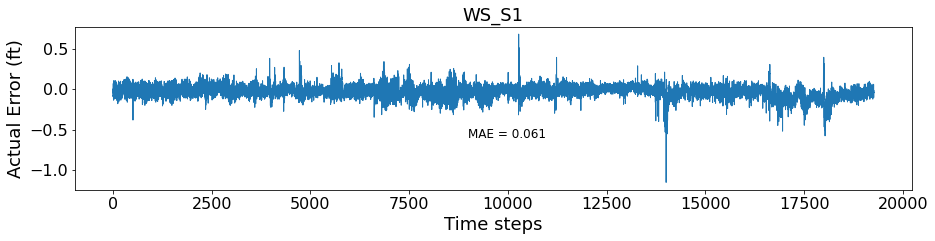

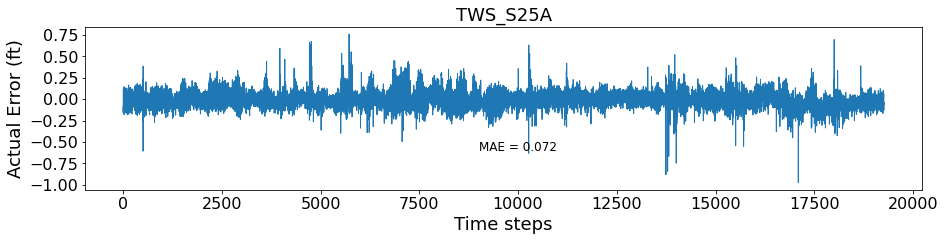

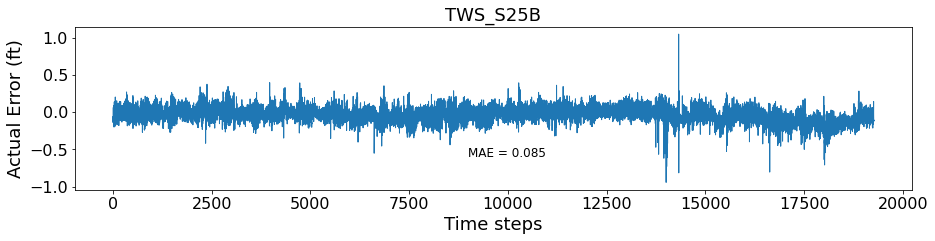

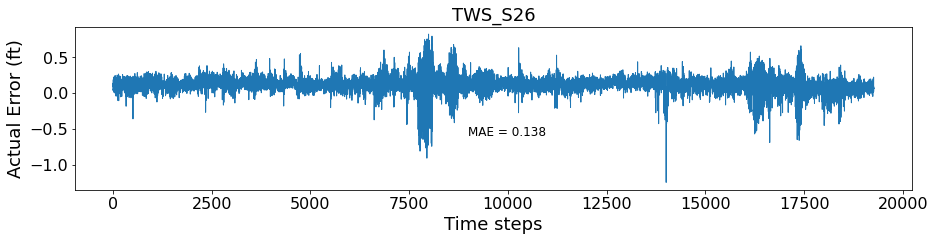

In [18]:
wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
inv_y_reshape = inv_y.reshape((-1, 24, 4))

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    plt.plot(error[:, -1, i], linewidth=1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Actual Error (ft)', fontsize=18)
    plt.title('{}'.format(wss[i]), fontsize=18)
    plt.text(9000, -0.6, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error[:, -1, i]))/len(error)))), fontsize=12)
    plt.show()

In [19]:
up_thre = 0.5
low_thre = -0.5

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre) + np.sum(error[:, -1, i] < low_thre))

(19268,)
15
(19268,)
30
(19268,)
31
(19268,)
162


In [20]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre))

(19268,)
2
(19268,)
18
(19268,)
2
(19268,)
96


In [21]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] < low_thre))

(19268,)
13
(19268,)
12
(19268,)
29
(19268,)
66
